[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Takfes/notes-deep-learning/blob/main/03_pytorch_classification.ipynb)

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
data = load_breast_cancer()
X = data['data']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1990)

In [16]:
sc = StandardScaler()
Xttr = sc.fit_transform(X_train)
Xtte = sc.transform(X_test)

In [31]:
Xtr = torch.tensor(Xttr)
Xte = torch.tensor(Xtte)
ytr = torch.tensor(y_train).unsqueeze(1)
yte = torch.tensor(y_test).unsqueeze(1)

In [32]:
[x.shape for x in [Xtr,Xte,ytr,yte]]

[torch.Size([381, 30]),
 torch.Size([188, 30]),
 torch.Size([381, 1]),
 torch.Size([188, 1])]

## Dataset + DataLoader

In [53]:
class Dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [40]:
train_dataset = Dataset(Xtr,ytr)
test_dataset = Dataset(Xte,yte)
print(f"{len(train_dataset)=}, {len(test_dataset)=}")

len(train_dataset)=381, len(test_dataset)=188


In [43]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    shuffle = True)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    shuffle = True)

In [51]:
print("number of train batches:",len(train_loader))
print("\ntrain batches:\n")
for i,(x,y) in enumerate(train_loader,start=1):
    print(i,x.shape,y.shape)

number of train batches: 12

train batches:

1 torch.Size([32, 30]) torch.Size([32, 1])
2 torch.Size([32, 30]) torch.Size([32, 1])
3 torch.Size([32, 30]) torch.Size([32, 1])
4 torch.Size([32, 30]) torch.Size([32, 1])
5 torch.Size([32, 30]) torch.Size([32, 1])
6 torch.Size([32, 30]) torch.Size([32, 1])
7 torch.Size([32, 30]) torch.Size([32, 1])
8 torch.Size([32, 30]) torch.Size([32, 1])
9 torch.Size([32, 30]) torch.Size([32, 1])
10 torch.Size([32, 30]) torch.Size([32, 1])
11 torch.Size([32, 30]) torch.Size([32, 1])
12 torch.Size([29, 30]) torch.Size([29, 1])


## Define Model

In [133]:
class Model(nn.Module):
    def __init__(self,input_features,output_features):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(input_features,16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, output_features)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [134]:
N_FEATURES = X.shape[1]
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 50

In [135]:
model = Model(N_FEATURES, 1)
criterion = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), 
                            lr = LEARNING_RATE, 
                            momentum = MOMENTUM)

In [124]:
# for i, x in enumerate(model.parameters(),start = 1):
#     print(i,x.shape)

## Poor Man's Training Loop

In [ ]:
A = []
L = []
for epoch in range(EPOCHS):
    model.train() # set the model to training mode
    for x,y in train_loader:
        x = x.float()
        y = y.float()
        # forward
        y_pred = model(x)
        # loss
        loss = criterion(y_pred,y)
        # zero gradient
        optimizer.zero_grad()
        # backward
        loss.backward()
        # update weights
        optimizer.step()
    
    # print epoch statistics
    output = (y_pred > 0.5).float()
    accuracy = (output == y).float().mean()
    print(f'{epoch=} | {loss=:.4f} | {accuracy=:.4f}')

    # log metrics
    L.append(loss.item())
    A.append(accuracy.item())

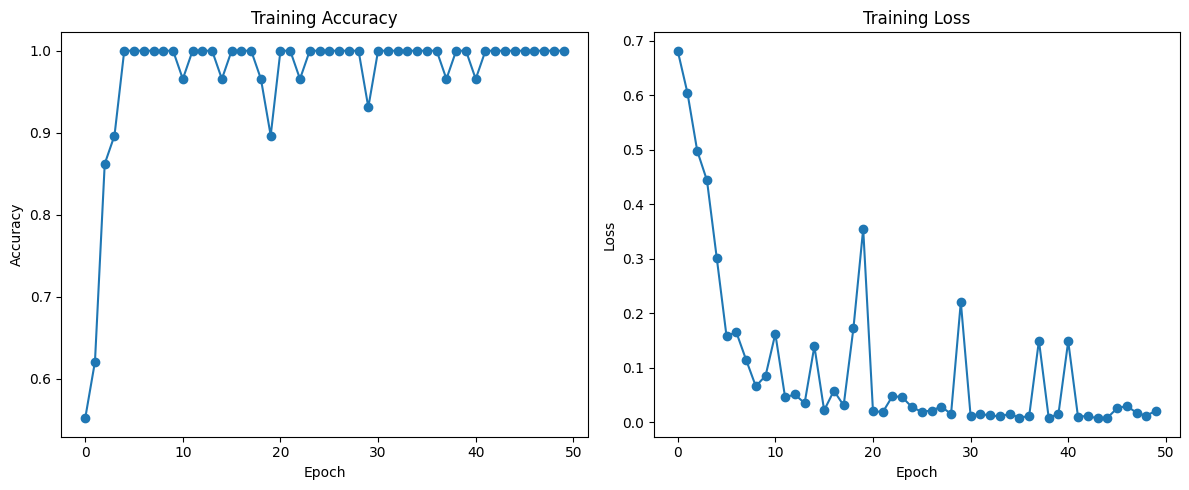

In [126]:
# Creating a subplot with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st plot)
plt.plot(A, marker='o', linestyle='-')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd plot)
plt.plot(L, marker='o', linestyle='-')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

## Better Training Loop

In [136]:
L_train = []  # List to store average loss per epoch for training
A_train = []  # List to store average accuracy per epoch for training
L_test = []   # List to store average loss per epoch for testing
A_test = []   # List to store average accuracy per epoch for testing

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    total_train_loss = 0
    total_train_accuracy = 0

    for x, y in train_loader:
        x = x.float()
        y = y.float()
        # Forward pass
        y_pred = model(x)
        # Compute loss
        loss = criterion(y_pred, y)
        # Zero gradients, backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        output = (y_pred > 0.5).float()
        accuracy = (output == y).float().mean()
        total_train_accuracy += accuracy.item()

    # Calculate average loss and accuracy for this epoch (training)
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = total_train_accuracy / len(train_loader)
    L_train.append(avg_train_loss)
    A_train.append(avg_train_accuracy)

    # Evaluation phase on test data
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    total_test_accuracy = 0
    with torch.no_grad():  # No need to track gradients
        for x_test, y_test in test_loader:
            x_test = x_test.float()
            y_test = y_test.float()
            y_test_pred = model(x_test)
            test_loss = criterion(y_test_pred, y_test)
            total_test_loss += test_loss.item()
            test_output = (y_test_pred > 0.5).float()
            test_accuracy = (test_output == y_test).float().mean()
            total_test_accuracy += test_accuracy.item()

    # Calculate average loss and accuracy for this epoch (testing)
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_accuracy = total_test_accuracy / len(test_loader)
    L_test.append(avg_test_loss)
    A_test.append(avg_test_accuracy)

    print(f'Epoch {epoch+1}/{EPOCHS} | '
          f'Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f} | '
          f'Test Loss: {avg_test_loss:.4f} | Test Accuracy: {avg_test_accuracy:.4f}')


Epoch 1/50 | Train Loss: 0.6476 | Train Accuracy: 0.6325 | Test Loss: 0.6413 | Test Accuracy: 0.6168
Epoch 2/50 | Train Loss: 0.6237 | Train Accuracy: 0.6335 | Test Loss: 0.6044 | Test Accuracy: 0.6190
Epoch 3/50 | Train Loss: 0.5781 | Train Accuracy: 0.6316 | Test Loss: 0.5402 | Test Accuracy: 0.6481
Epoch 4/50 | Train Loss: 0.4977 | Train Accuracy: 0.8148 | Test Loss: 0.4352 | Test Accuracy: 0.9062
Epoch 5/50 | Train Loss: 0.3886 | Train Accuracy: 0.9289 | Test Loss: 0.3199 | Test Accuracy: 0.9360
Epoch 6/50 | Train Loss: 0.2857 | Train Accuracy: 0.9370 | Test Loss: 0.2281 | Test Accuracy: 0.9464
Epoch 7/50 | Train Loss: 0.2101 | Train Accuracy: 0.9505 | Test Loss: 0.1707 | Test Accuracy: 0.9635
Epoch 8/50 | Train Loss: 0.1641 | Train Accuracy: 0.9578 | Test Loss: 0.1382 | Test Accuracy: 0.9784
Epoch 9/50 | Train Loss: 0.1328 | Train Accuracy: 0.9682 | Test Loss: 0.1176 | Test Accuracy: 0.9792
Epoch 10/50 | Train Loss: 0.1163 | Train Accuracy: 0.9711 | Test Loss: 0.1066 | Test Accura

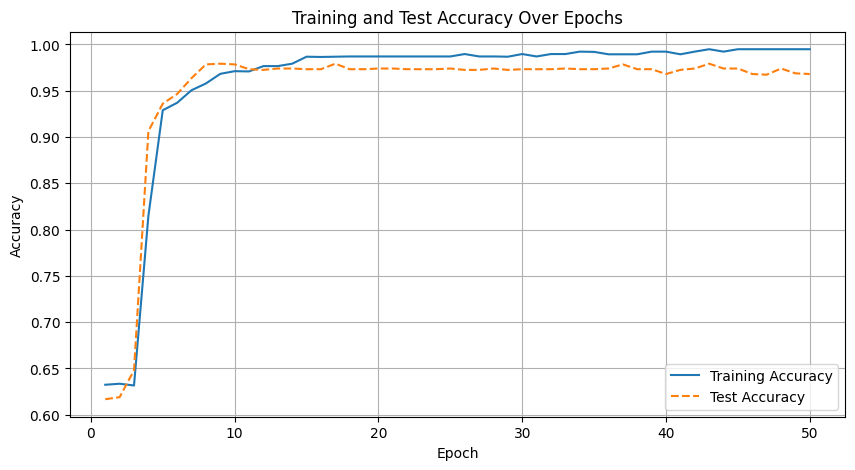

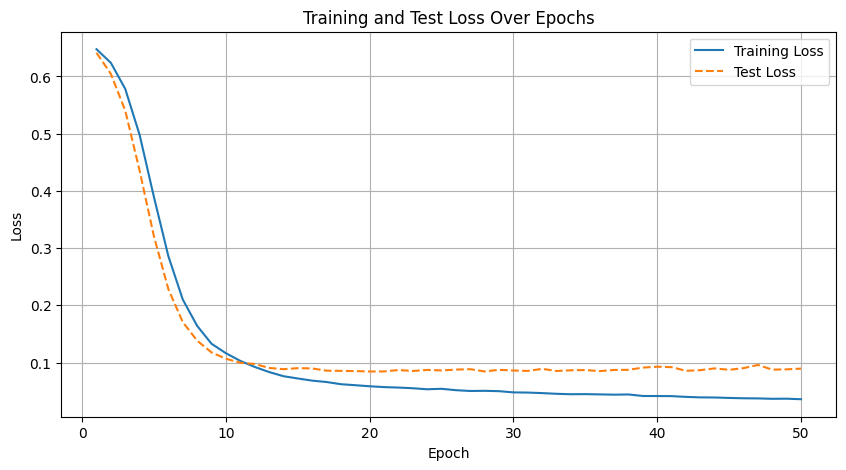

In [137]:
# Updating the plotting function to visualize training and test metrics

def plot_training_and_test_metrics(train_metrics, test_metrics, metric_name):
    epochs = range(1, len(train_metrics) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_metrics, label=f'Training {metric_name}')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', linestyle='--')
    plt.title(f'Training and Test {metric_name} Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.show()

# Plotting accuracy and loss for both training and test data
plot_training_and_test_metrics(A_train, A_test, 'Accuracy')
plot_training_and_test_metrics(L_train, L_test, 'Loss')
